In [1]:
from torchvision import transforms
import numpy as np
import torch
from torchvision.transforms import functional as F
import torch.optim as optim
import torch
import torch.nn as nn
import torchvision
import clip
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader, random_split
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

/root/env/deep_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class VOCColormap:
    def __init__(self):
        self.colormap = np.array([
            [0, 0, 0],          # background
            [128, 0, 0],        # aeroplane
            [0, 128, 0],        # bicycle
            [128, 128, 0],      # bird
            [0, 0, 128],        # boat
            [128, 0, 128],      # bottle
            [0, 128, 128],      # bus
            [128, 128, 128],    # car
            [64, 0, 0],         # cat
            [192, 0, 0],        # chair
            [64, 128, 0],       # cow
            [192, 128, 0],      # diningtable
            [64, 0, 128],       # dog
            [192, 0, 128],      # horse
            [64, 128, 128],     # motorbike
            [192, 128, 128],    # person
            [0, 64, 0],         # pottedplant
            [128, 64, 0],       # sheep
            [0, 192, 0],        # sofa
            [128, 192, 0],      # train
            [0, 64, 128],       # tvmonitor
            [128, 64, 128],     # ignored/255
        ], dtype=np.uint8)
    
    def apply_colormap(self, mask):
        """Convertit le masque de segmentation pour colorer l'image
        
        Args:
            mask : le masque à convertir    
        """
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        
        # Remplace -1 par 21 pour la visualisation
        colored_mask = np.copy(mask)
        colored_mask[colored_mask == -1] = 21
        colored_mask = colored_mask.astype(int)
        
        # Appliquer la colormap
        return self.colormap[colored_mask]

def visualize_data(images, masks, predictions=None, num_samples=5):
    """
    Visualise les images, masques ground truth et prédictions
    
    Args:
        images: les images normalisées normalisé
        masks: les masques avec valeurs de classe
        predictions: les valeurs de classe prédites
        num_samples: nombre d'échantillons à afficher
    """
    # Dénormalisation des images
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    denorm = transforms.Normalize(
        mean=(-mean / std).tolist(),
        std=(1.0 / std).tolist()
    )
    
    # Nombre d'images à afficher
    n = min(num_samples, len(images))
    
    # Configurer la figure
    if predictions is not None:
        _, axs = plt.subplots(n, 3, figsize=(15, 5*n))
        titles = ['Image', 'Ground Truth', 'Prediction']
    else:
        _, axs = plt.subplots(n, 2, figsize=(10, 5*n))
        titles = ['Image', 'Ground Truth']
    
    colormap = VOCColormap()
    
    for i in range(n):
        # Image originale
        img = denorm(images[i]).cpu().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        # Masque ground truth
        mask = masks[i].cpu().numpy()
        colored_mask = colormap.apply_colormap(mask=mask)
        
        if predictions is not None:
            # Prédiction
            pred = predictions[i].cpu().numpy()
            colored_pred = colormap.apply_colormap(mask=pred)
            
            axs[i, 0].imshow(img)
            axs[i, 1].imshow(colored_mask)
            axs[i, 2].imshow(colored_pred)
        else:
            axs[i, 0].imshow(img)
            axs[i, 1].imshow(colored_mask)
        
        # Configurer les sous-plots
        for j, title in enumerate(titles):
            axs[i, j].set_title(f'{title} - Sample {i+1}')
            axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_training_data(train_loader, num_samples=5):
    """Visualiser quelques échantillons d'entraînement
    Args:
        train_loader: les données d'entrainement
        num_sample: le nombre d'images à afficher
    """
    images, masks = next(iter(train_loader))
    visualize_data(images=images, masks=masks, num_samples=num_samples)

def visualize_validation_results(model, val_loader, device, num_samples=5):
    """Visualiser les résultats sur quelques échantillons de validation
    Args:
        model: le modèle à utiliser pour les prédictions
        val_loader: les données de validation
        device: cpu ou cuda
        num_samples: le nombre d'images à afficher
    """
    model.eval()
    with torch.no_grad():
        images, masks = next(iter(val_loader))
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)
        
        visualize_data(images=images, masks=masks, predictions=predictions, num_samples=num_samples)

In [3]:
class CustomModel(nn.Module):
    def __init__(self, num_classes=21, prompt_length=30, device="cuda"):
        """Initialisation de notre modèle contenant le générateur, clip et le prompt
        Args:
            num_classes: le nombre de classes du jeu de données (ici 21 car 20 classes + background pour Pascal VOC)
            prompt_length: la taille maximum du prompt
            device: cpu ou cuda
        """
        super().__init__()
        # DeepLabV3 comme générateur de masque, préentrainé sur Coco avec les 21 classes de pascalVoc
        self.mask_generator = deeplabv3_resnet101(pretrained=True).to(device)
        
        # Chargement de CLIP
        self.clip_model, self.clip_preprocess = clip.load("ViT-B/32", device=device)

        # Création du prompt
        self.prompts = nn.Parameter(torch.randn(num_classes, prompt_length, self.clip_model.token_embedding.weight.size(1), device=device))

        # Gel des paramètres de CLIP (nous ne faisons qu'utiliser ses fonctions d'encodage)
        for param in self.clip_model.parameters():
            param.requires_grad = False

        # Liste des classes de pascal VOC 2012
        self.voc_classes = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
                           'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 
                           'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 
                           'train', 'tvmonitor']

    def forward(self, images):
        """ Génération des masques
        Args:
            images: les images à passer au générateur
        
        Return:
            Un Tensor avec les masques prédits
        """
        mask_output = self.mask_generator(images)
        masks = mask_output['out']  # format [B, C, H, W] : récupération des masques prédits
        return masks

class VOCDatasetWithCLIP(VOCSegmentation): # Créé ainsi pour permettre une plus grande flexibilité si on changeait de jeu de données
    def __init__(self, root, year='2012', image_set='train', transform=None, target_transform=None):
        """Initialisation de notre jeu de données
        Args:
            root: le chemin menant au dossier où sont enregsitrées les données
            year: l'année du jeu de données
            image_set: l'ensemble de données voulu (train, val ou trainval)
            transform: la transformation à appliquer aux images
            target_transform: la transformation à appliquer aux masques
        """
        super().__init__(root=root, year=year, image_set=image_set, transform=transform, target_transform=target_transform, download=True)
        
    def __getitem__(self, index):
        # Charger l'image et le masque à partir de leurs chemins
        img = Image.open(self.images[index]).convert("RGB")  # Charger l'image en RGB
        mask = Image.open(self.masks[index])  # Charger le masque

        # Appliquer les transformations. Deux transformations sont nécessaires car les masques sont également des images
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            mask = self.target_transform(mask)
        
        # Remplacer les valeurs de masque 255 (ignored) par -1
        mask = mask.long()
        mask[mask == 255] = -1
        
        return img, mask
    
def match_loss(foreground_features, text_features, background_features, lambda_b):
    foreground_similarity = torch.cosine_similarity(foreground_features, text_features, dim=-1)
    foreground_similarity = torch.clamp(foreground_similarity, min=1e-6)
    background_similarity = torch.cosine_similarity(background_features, text_features, dim=-1)
    background_similarity = torch.clamp(background_similarity, min=0.0, max=1 - 1e-6)
    loss = -torch.log(foreground_similarity).mean() - lambda_b * torch.log(1 - background_similarity).mean()
    return loss

def prompt_loss(background_prompts, text_features, background_features, lambda_T):
    averaged_prompt = background_prompts.mean(dim=0)
    prompt_alignment = torch.cosine_similarity(averaged_prompt.unsqueeze(0), background_features, dim=-1)
    prompt_alignment = torch.clamp(prompt_alignment, min=1e-6)
    prompt_repulsion = torch.cosine_similarity(averaged_prompt.unsqueeze(0), text_features, dim=-1)
    prompt_repulsion = torch.clamp(prompt_repulsion, min=0.0, max=1 - 1e-6)
    loss = -torch.log(prompt_alignment).mean() - lambda_T * torch.log(1 - prompt_repulsion).mean()
    return loss

def refine_loss(foreground_features, background_prompts):
    averaged_prompt = background_prompts.mean(dim=0)
    refinement = torch.cosine_similarity(foreground_features, averaged_prompt.unsqueeze(0), dim=-1)
    refinement = torch.clamp(refinement, min=0.0, max=1 - 1e-6)
    return - torch.log(1 - refinement).mean()

def train_one_epoch(model, train_loader, optimizer, device, lambdas):
    """ Entrainement du modèle pour une epoch
    Args:
        model: le modèle à utiliser (générateur, prompt et clip dans notre cas)
        train_loader: les données d'entrainement
        optimizer: l'optimizer à utiliser
        device: cpu ou cuda
        lambdas: les différents hyperparamètres lambdas pour les fonctions de loss
    
    Return:
        La loss de cette epoch
    """
    model.train()
    total_loss = 0
    
    for images, masks in tqdm(train_loader):
        torch.cuda.empty_cache()
        images = images.to(device)  # dimensions [B, 3, H, W]
        masks = masks.to(device)    # dimensions [B, H, W]
        
        optimizer.zero_grad()
        
        # Génération des masques
        pred_masks = model(images)  # dimensions [B, C, H, W]
        
        # Convertir les masques prédits en probabilités (ici argmax n'est pas utilisé car cela coupe le suivi du gradient)
        pred_masks = torch.sigmoid(pred_masks)  # dimensions [B, C, H, W]
        
        # Préparer tous les textes pour toutes les classes (en ignorant la classe background (c=0))
        text_inputs = [f"a photo of {model.voc_classes[c]}" for c in range(1, pred_masks.shape[1])]
        text_tokens = clip.tokenize(text_inputs).to(device)
        
        # Encoder tous les textes d'un coup
        with torch.no_grad():
            text_features = model.clip_model.encode_text(text_tokens)  # dimensions [C-1, D]
        
        class_total_loss = 0
        # Pour chaque classe (sauf background)
        for c in range(1, pred_masks.shape[1]):
            # Trouver les images qui contiennent cette classe
            class_present = (masks == c).any(dim=1).any(dim=1)
            if not class_present.any():
                continue
                
            # Sélectionner les images pertinentes
            relevant_images = images[class_present]  # dimensions [B', 3, H, W]
            relevant_masks = pred_masks[class_present, c]  # dimensions [B', H, W]
            
            # Créer les images foreground et background
            foreground = relevant_images * relevant_masks.unsqueeze(1)  # dimensions [B', 3, H, W]
            background = relevant_images * (1 - relevant_masks.unsqueeze(1))  # dimensions [B', 3, H, W]

            # Encoder toutes les images foreground et background d'un coup
            fore_features = model.clip_model.encode_image(foreground)  # dimensions [B', D]
            back_features = model.clip_model.encode_image(background)  # dimensions  [B', D]
            
            # Calcule de la loss pour cette classe à partir des 3 loss
            class_match_loss = match_loss(foreground_features=fore_features, text_features=text_features[c-1].unsqueeze(0),
                                          background_features=back_features, lambda_b=lambdas["lambda_b"])
            class_prompt_loss = prompt_loss(background_prompts=model.prompts[c], text_features=text_features[c-1].unsqueeze(0),
                                            background_features=back_features, lambda_T=lambdas["lambda_T"])
            class_refine_loss = refine_loss(foreground_features=fore_features, background_prompts=model.prompts[c])
            class_total_loss += (class_match_loss + lambdas["lambda"] * class_refine_loss + class_prompt_loss)
        
        # Normaliser la loss par le nombre de classes
        loss = class_total_loss / (pred_masks.shape[1] - 1)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def calculate_miou(pred_classes, true_masks, num_classes=21):
    """ Calcul de la matrice de confusion pour la miou
    Args:
        pred_classes: les masques prédits
        true_masks: les ground truth
        num_classes: le nombre de classes dans le jeu de données
    
    Return:
        La matrice de confusion permettant le calcul de miou
    """

    # On ignore les valeurs non prises en compte dans le masque d'origine (mises à -1 lors de la création du jeu de données)
    valid_mask = true_masks != -1
    
    # Ne récupère que les pixels à prendre en compte, convertit en numpy pour les calculs et l'applatit pour la matrice
    pred_flat = pred_classes[valid_mask].cpu().numpy().flatten()
    true_flat = true_masks[valid_mask].cpu().numpy().flatten()
    
    # Création de la matrice de confusion
    confusion_mat = confusion_matrix(
        true_flat, 
        pred_flat,
        labels=list(range(num_classes))
    )
    
    return confusion_mat

def validate(model, val_loader, device, lambdas):
    """ Calcule la loss et miou sur les jeu de données de validation
    Args:
        model: le modèle à utiliser
        val_loader: les données de validation
        lambdas: les différents hyperparamètres lambdas pour les fonctions de loss

    Return:
        La loss et la miou calculées sur les données de validation
    """
    model.eval()
    confusion_mat_total = None
    total_loss = 0
    
    with torch.no_grad():
        for images, masks in tqdm(val_loader):
            torch.cuda.empty_cache()
            images = images.to(device)
            masks = masks.to(device)
            
            # Récupération des prédictions
            pred_masks = model(images)
            
            # Calcul du mIoU avec argmax pour avoir les classes prédites
            pred_classes = torch.argmax(pred_masks, dim=1)  # dimensions [B, H, W]
            batch_conf_mat = calculate_miou(pred_classes=pred_classes, true_masks=masks)
            
            if confusion_mat_total is None:
                confusion_mat_total = batch_conf_mat
            else:
                confusion_mat_total += batch_conf_mat
            
            # Pour les loss, on utilise sigmoid pour avoir des masques soft
            pred_masks_soft = torch.sigmoid(pred_masks)  # dimensions [B, C, H, W]
            
            # Prépration des textes
            text_inputs = [f"a photo of {model.voc_classes[c]}" for c in range(1, pred_masks.shape[1])]
            text_tokens = clip.tokenize(text_inputs).to(device)
            
            text_features = model.clip_model.encode_text(text_tokens)
            
            class_total_loss = 0
            for c in range(1, pred_masks.shape[1]):
                class_present = (masks == c).any(dim=1).any(dim=1)
                if not class_present.any():
                    continue
                    
                # Sélection des images pertinentes
                relevant_images = images[class_present]
                relevant_masks = pred_masks_soft[class_present, c]
                
                # Création des images foreground et background
                foreground = relevant_images * relevant_masks.unsqueeze(1)
                background = relevant_images * (1 - relevant_masks.unsqueeze(1))
                
                fore_features = model.clip_model.encode_image(foreground)
                back_features = model.clip_model.encode_image(background)
                
                # Calcule de la loss pour cette classe à partir des 3 loss
                class_match_loss = match_loss(foreground_features=fore_features, text_features=text_features[c-1].unsqueeze(0),
                                            background_features=back_features, lambda_b=lambdas["lambda_b"])
                class_prompt_loss = prompt_loss(background_prompts=model.prompts[c], text_features=text_features[c-1].unsqueeze(0),
                                                background_features=back_features, lambda_T=lambdas["lambda_T"])
                class_refine_loss = refine_loss(foreground_features=fore_features, background_prompts=model.prompts[c])
                class_total_loss += (class_match_loss + lambdas["lambda"] * class_refine_loss + class_prompt_loss)
        
            # Normaliser la loss par le nombre de classes
            loss = class_total_loss / (pred_masks.shape[1] - 1)
            total_loss += loss.item()
    
    # Calcul final des métriques
    intersection = np.diag(confusion_mat_total)
    gt_set = confusion_mat_total.sum(axis=1)
    pred_set = confusion_mat_total.sum(axis=0)
    union = gt_set + pred_set - intersection
    
    class_ious = intersection / (union + 1e-6)
    valid_classes = union > 0
    miou = class_ious[valid_classes].mean()
    
    # Calculer la loss moyenne
    avg_loss = total_loss / len(val_loader)
        
    return avg_loss, miou

def mask_transform(mask):
    # Redimensionner avec interpolation nearest pour préserver les classes
    mask = F.resize(mask, (224, 224), interpolation=Image.NEAREST)
    # Convertir en numpy array pour manipuler les valeurs discrètes
    mask = np.array(mask, dtype=np.uint8)  # np.uint8 pour correspondre aux valeurs originales
    return torch.from_numpy(mask) 

In [ ]:
# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 60
batch_size = 32
learning_rate = 5e-4
lambdas =  {"lambda_b": 2.4, "lambda_T":  0.02, "lambda":0.05}

# Data loading
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = VOCDatasetWithCLIP(root='./data', image_set="train", transform=transform, target_transform=mask_transform)
val_dataset = VOCDatasetWithCLIP(root='./data', image_set="val", transform=transform, target_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar


In [5]:
print("train", len(train_dataset), "val", len(val_dataset))

train 1464 val 1449


Visualisation des données d'entraînement:


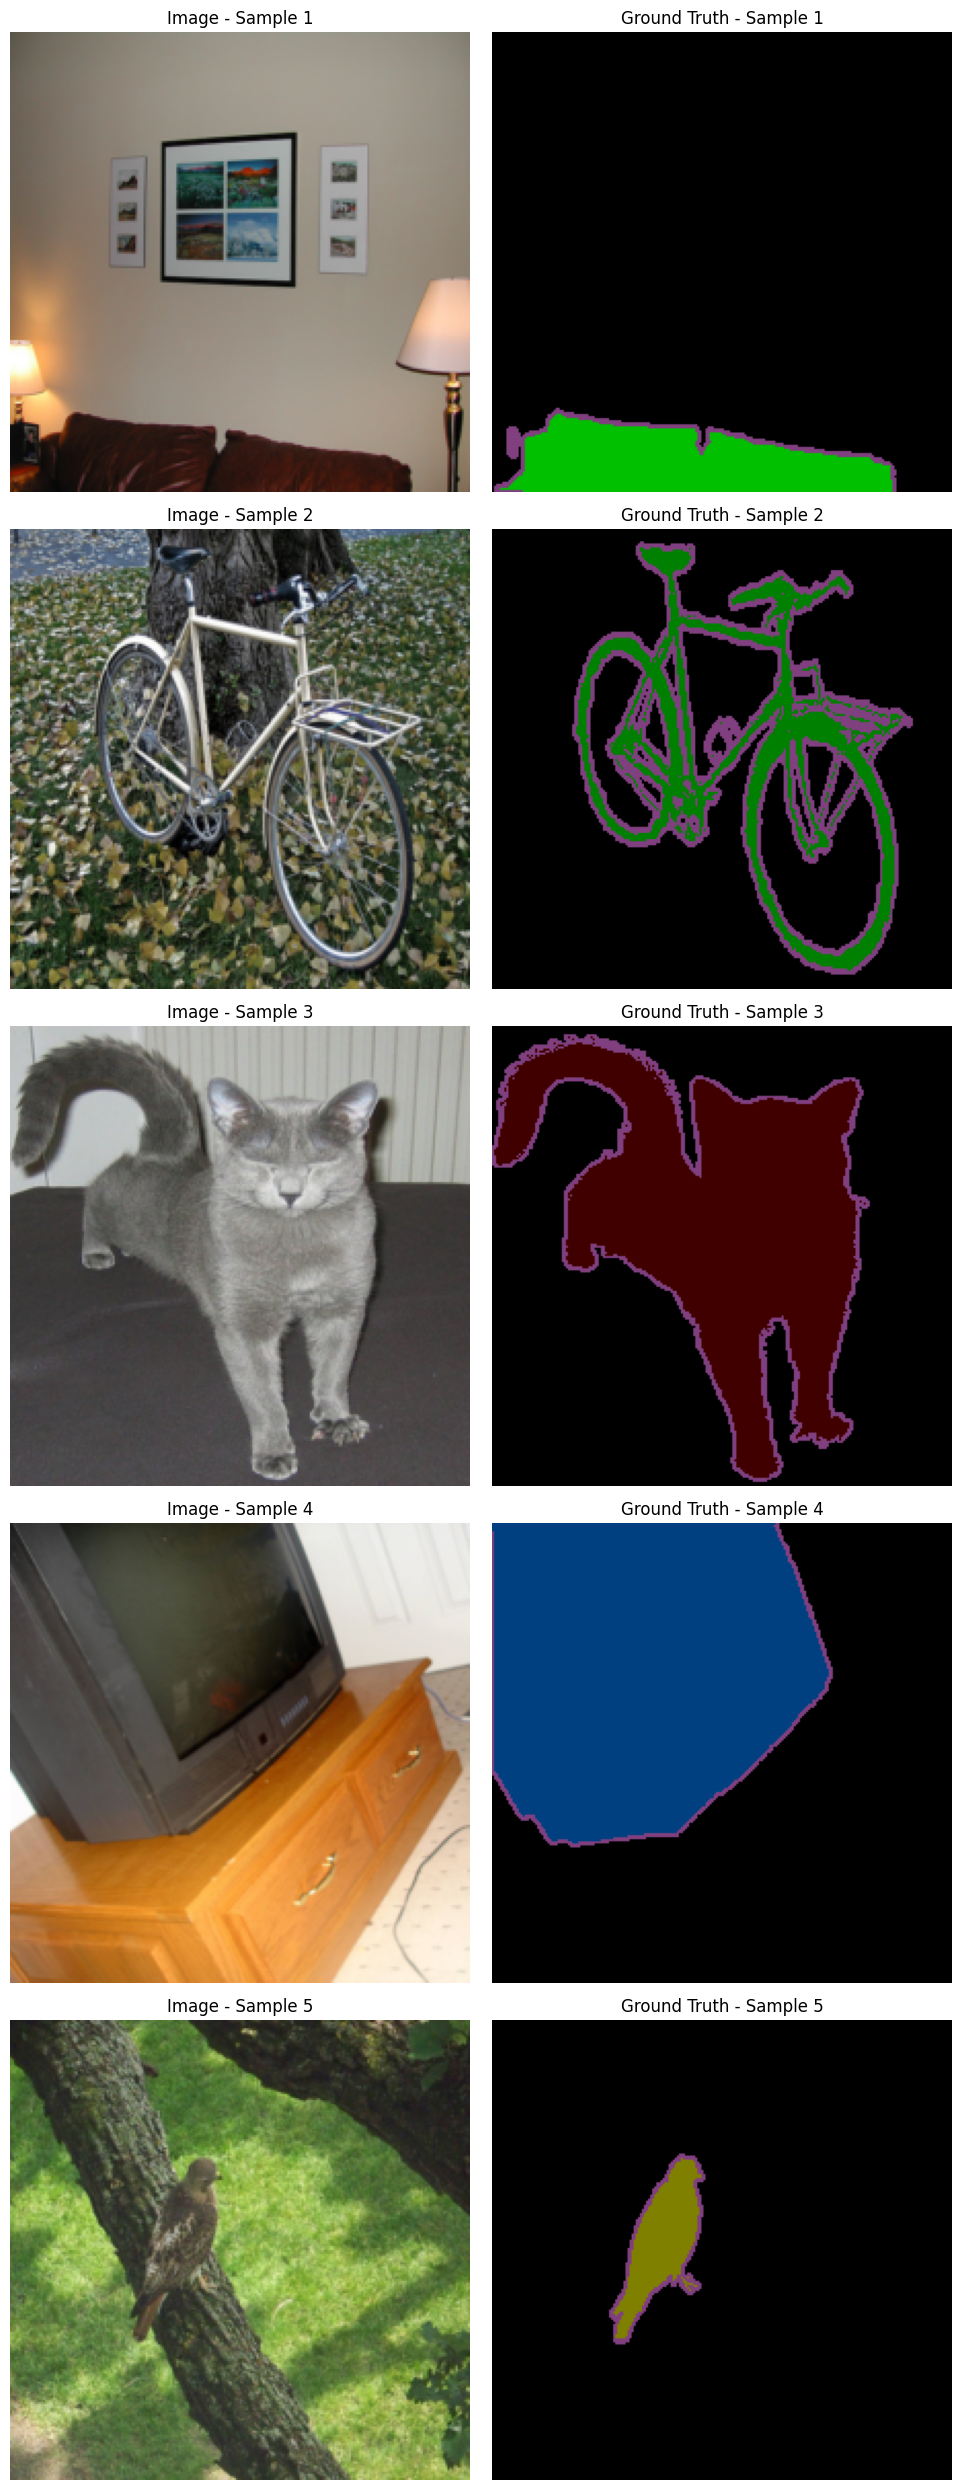

In [ ]:
print("Visualisation des données d'entraînement:")
visualize_training_data(train_loader=train_loader)

In [7]:
# Création du modèle
model = CustomModel().to(device)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

torch.cuda.empty_cache()
# Boucle d'entraînement
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model=model, train_loader=train_loader, optimizer=optimizer, device=device, lambdas=lambdas)
    val_loss, val_miou = validate(model=model, val_loader=val_loader, device=device, lambdas=lambdas)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss} - Validation Loss: {val_loss} - Validation mIoU: {val_miou:.4f}")

    scheduler.step()

  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [00:46<00:00,  1.02s/it]


Epoch 1/60 - Train Loss: 8.304179948309194 - Validation Loss: 7.839420422263768 - Validation mIoU: 0.0322


100%|██████████| 46/46 [00:49<00:00,  1.08s/it]


Epoch 2/60 - Train Loss: 7.0060844317726465 - Validation Loss: 6.4357671634010645 - Validation mIoU: 0.0337


100%|██████████| 46/46 [00:47<00:00,  1.04s/it]


Epoch 3/60 - Train Loss: 5.786016536795574 - Validation Loss: 5.635625227637913 - Validation mIoU: 0.0342


100%|██████████| 46/46 [00:44<00:00,  1.03it/s]


Epoch 4/60 - Train Loss: 5.331861340481302 - Validation Loss: 5.207377915797026 - Validation mIoU: 0.0349


100%|██████████| 46/46 [00:45<00:00,  1.01it/s]


Epoch 5/60 - Train Loss: 4.936496268148008 - Validation Loss: 4.895629203837851 - Validation mIoU: 0.0350


100%|██████████| 46/46 [00:43<00:00,  1.07it/s]


Epoch 6/60 - Train Loss: 4.737761331641155 - Validation Loss: 4.675903211469236 - Validation mIoU: 0.0347


100%|██████████| 46/46 [00:45<00:00,  1.02it/s]


Epoch 7/60 - Train Loss: 4.656907247460407 - Validation Loss: 4.593502311602883 - Validation mIoU: 0.0348


100%|██████████| 46/46 [00:43<00:00,  1.05it/s]


Epoch 8/60 - Train Loss: 4.553991224454797 - Validation Loss: 4.414122990939928 - Validation mIoU: 0.0349


100%|██████████| 46/46 [00:49<00:00,  1.08s/it]


Epoch 9/60 - Train Loss: 4.4898523558741035 - Validation Loss: 4.418023757312609 - Validation mIoU: 0.0349


100%|██████████| 46/46 [00:47<00:00,  1.02s/it]


Epoch 10/60 - Train Loss: 4.46733658210091 - Validation Loss: 4.257385927697887 - Validation mIoU: 0.0349


100%|██████████| 46/46 [00:55<00:00,  1.20s/it]


Epoch 11/60 - Train Loss: 4.313527366389399 - Validation Loss: 4.4317106060359786 - Validation mIoU: 0.0335


100%|██████████| 46/46 [00:41<00:00,  1.10it/s]


Epoch 12/60 - Train Loss: 4.322701796241429 - Validation Loss: 4.252352939999622 - Validation mIoU: 0.0349


100%|██████████| 46/46 [00:46<00:00,  1.02s/it]


Epoch 13/60 - Train Loss: 4.21339369856793 - Validation Loss: 4.121443831402322 - Validation mIoU: 0.0349


100%|██████████| 46/46 [00:41<00:00,  1.12it/s]


Epoch 14/60 - Train Loss: 4.152995104375093 - Validation Loss: 4.186294223951257 - Validation mIoU: 0.0349


100%|██████████| 46/46 [00:43<00:00,  1.07it/s]


Epoch 15/60 - Train Loss: 4.1510505520779155 - Validation Loss: 4.064972359201183 - Validation mIoU: 0.0346


100%|██████████| 46/46 [00:53<00:00,  1.17s/it]


Epoch 16/60 - Train Loss: 4.042553580325583 - Validation Loss: 3.9628257155418396 - Validation mIoU: 0.0329


100%|██████████| 46/46 [00:48<00:00,  1.06s/it]


Epoch 17/60 - Train Loss: 3.878238812736843 - Validation Loss: 3.801767623942831 - Validation mIoU: 0.0349


100%|██████████| 46/46 [00:53<00:00,  1.15s/it]


Epoch 18/60 - Train Loss: 3.6759880573853203 - Validation Loss: 3.635314614876457 - Validation mIoU: 0.0349


100%|██████████| 46/46 [00:47<00:00,  1.02s/it]


Epoch 19/60 - Train Loss: 3.6524036397104678 - Validation Loss: 3.5463111271028933 - Validation mIoU: 0.0349


100%|██████████| 46/46 [00:49<00:00,  1.08s/it]


Epoch 20/60 - Train Loss: 3.579950731733571 - Validation Loss: 3.5171919205914373 - Validation mIoU: 0.0349


100%|██████████| 46/46 [00:56<00:00,  1.23s/it]


Epoch 21/60 - Train Loss: 3.544574182966481 - Validation Loss: 3.47958730355553 - Validation mIoU: 0.0349


100%|██████████| 46/46 [00:43<00:00,  1.06it/s]


Epoch 22/60 - Train Loss: 3.480945592341216 - Validation Loss: 3.518490387045819 - Validation mIoU: 0.0349


100%|██████████| 46/46 [00:47<00:00,  1.04s/it]


Epoch 23/60 - Train Loss: 3.451165525809578 - Validation Loss: 3.4340283248735513 - Validation mIoU: 0.0349


100%|██████████| 46/46 [00:41<00:00,  1.10it/s]


Epoch 24/60 - Train Loss: 3.4621638992558355 - Validation Loss: 3.4582261624543564 - Validation mIoU: 0.0349


100%|██████████| 46/46 [00:43<00:00,  1.05it/s]


Epoch 25/60 - Train Loss: 3.4606096744537354 - Validation Loss: 3.300628654334856 - Validation mIoU: 0.0348


100%|██████████| 46/46 [00:48<00:00,  1.05s/it]


Epoch 26/60 - Train Loss: 3.378942499990049 - Validation Loss: 3.362949042216591 - Validation mIoU: 0.0349


100%|██████████| 46/46 [00:47<00:00,  1.03s/it]


Epoch 27/60 - Train Loss: 3.386673004730888 - Validation Loss: 3.290290241656096 - Validation mIoU: 0.0333


100%|██████████| 46/46 [00:56<00:00,  1.24s/it]


Epoch 28/60 - Train Loss: 3.3378416921781455 - Validation Loss: 3.3779053247493245 - Validation mIoU: 0.0329


100%|██████████| 46/46 [00:42<00:00,  1.08it/s]


Epoch 29/60 - Train Loss: 3.3063972981079766 - Validation Loss: 3.2825231318888455 - Validation mIoU: 0.0323


100%|██████████| 46/46 [00:44<00:00,  1.04it/s]


Epoch 30/60 - Train Loss: 3.2543206577715664 - Validation Loss: 3.2899937629699707 - Validation mIoU: 0.0322


100%|██████████| 46/46 [00:51<00:00,  1.13s/it]


Epoch 31/60 - Train Loss: 3.210562685261602 - Validation Loss: 3.297503043775973 - Validation mIoU: 0.0314


100%|██████████| 46/46 [00:47<00:00,  1.03s/it]


Epoch 32/60 - Train Loss: 3.3429597927176435 - Validation Loss: 3.315605044364929 - Validation mIoU: 0.0308


100%|██████████| 46/46 [00:51<00:00,  1.12s/it]


Epoch 33/60 - Train Loss: 3.300868210585221 - Validation Loss: 3.224869756594948 - Validation mIoU: 0.0288


100%|██████████| 46/46 [00:44<00:00,  1.03it/s]


Epoch 34/60 - Train Loss: 3.251235220743262 - Validation Loss: 3.2599117678144705 - Validation mIoU: 0.0300


100%|██████████| 46/46 [00:48<00:00,  1.06s/it]


Epoch 35/60 - Train Loss: 3.2454923391342163 - Validation Loss: 3.257677575816279 - Validation mIoU: 0.0278


100%|██████████| 46/46 [00:46<00:00,  1.01s/it]


Epoch 36/60 - Train Loss: 3.2555419984071152 - Validation Loss: 3.222970531038616 - Validation mIoU: 0.0272


100%|██████████| 46/46 [00:50<00:00,  1.09s/it]


Epoch 37/60 - Train Loss: 3.205068712649138 - Validation Loss: 3.239418669887211 - Validation mIoU: 0.0283


100%|██████████| 46/46 [00:46<00:00,  1.02s/it]


Epoch 38/60 - Train Loss: 3.2281706747801406 - Validation Loss: 3.1999752443769705 - Validation mIoU: 0.0274


100%|██████████| 46/46 [00:44<00:00,  1.03it/s]


Epoch 39/60 - Train Loss: 3.17542548801588 - Validation Loss: 3.153845193593398 - Validation mIoU: 0.0272


100%|██████████| 46/46 [00:55<00:00,  1.22s/it]


Epoch 40/60 - Train Loss: 3.200478470843771 - Validation Loss: 3.1697076662727026 - Validation mIoU: 0.0261


100%|██████████| 46/46 [00:48<00:00,  1.05s/it]


Epoch 41/60 - Train Loss: 3.2179815924685933 - Validation Loss: 3.1350583330444666 - Validation mIoU: 0.0265


100%|██████████| 46/46 [00:49<00:00,  1.08s/it]


Epoch 42/60 - Train Loss: 3.1068663182465928 - Validation Loss: 3.1887208560238713 - Validation mIoU: 0.0255


100%|██████████| 46/46 [00:46<00:00,  1.01s/it]


Epoch 43/60 - Train Loss: 3.220780471096868 - Validation Loss: 3.1578555599502893 - Validation mIoU: 0.0251


100%|██████████| 46/46 [01:01<00:00,  1.34s/it]


Epoch 44/60 - Train Loss: 3.162010343178459 - Validation Loss: 3.1326637967773108 - Validation mIoU: 0.0263


100%|██████████| 46/46 [00:53<00:00,  1.16s/it]


Epoch 45/60 - Train Loss: 3.136408728101979 - Validation Loss: 3.158928772677546 - Validation mIoU: 0.0257


100%|██████████| 46/46 [00:46<00:00,  1.01s/it]


Epoch 46/60 - Train Loss: 3.163171156592991 - Validation Loss: 3.0986905383027117 - Validation mIoU: 0.0243


100%|██████████| 46/46 [00:44<00:00,  1.04it/s]


Epoch 47/60 - Train Loss: 3.1461577570956685 - Validation Loss: 3.0912116144014443 - Validation mIoU: 0.0246


100%|██████████| 46/46 [00:51<00:00,  1.12s/it]


Epoch 48/60 - Train Loss: 3.1967971532241157 - Validation Loss: 3.1959842184315557 - Validation mIoU: 0.0250


100%|██████████| 46/46 [00:57<00:00,  1.24s/it]


Epoch 49/60 - Train Loss: 3.162645168926405 - Validation Loss: 3.1377037193464195 - Validation mIoU: 0.0249


100%|██████████| 46/46 [00:49<00:00,  1.08s/it]


Epoch 50/60 - Train Loss: 3.1703671165134595 - Validation Loss: 3.118633982927903 - Validation mIoU: 0.0246


100%|██████████| 46/46 [00:41<00:00,  1.11it/s]


Epoch 51/60 - Train Loss: 3.120686603629071 - Validation Loss: 3.09097335131272 - Validation mIoU: 0.0250


100%|██████████| 46/46 [00:43<00:00,  1.05it/s]


Epoch 52/60 - Train Loss: 3.1572660985200303 - Validation Loss: 3.111764342888542 - Validation mIoU: 0.0252


100%|██████████| 46/46 [00:50<00:00,  1.10s/it]


Epoch 53/60 - Train Loss: 3.159245034922724 - Validation Loss: 3.079937432123267 - Validation mIoU: 0.0252


100%|██████████| 46/46 [00:48<00:00,  1.06s/it]


Epoch 54/60 - Train Loss: 3.10338192400725 - Validation Loss: 3.1728653233984243 - Validation mIoU: 0.0243


100%|██████████| 46/46 [00:51<00:00,  1.13s/it]


Epoch 55/60 - Train Loss: 3.1773406526316768 - Validation Loss: 3.1580036878585815 - Validation mIoU: 0.0252


100%|██████████| 46/46 [00:45<00:00,  1.01it/s]


Epoch 56/60 - Train Loss: 3.114206402198128 - Validation Loss: 3.0622237894846047 - Validation mIoU: 0.0254


100%|██████████| 46/46 [00:43<00:00,  1.06it/s]


Epoch 57/60 - Train Loss: 3.1405479389688242 - Validation Loss: 3.0319114612496416 - Validation mIoU: 0.0256


100%|██████████| 46/46 [00:51<00:00,  1.11s/it]


Epoch 58/60 - Train Loss: 3.136422986569612 - Validation Loss: 3.121077306892561 - Validation mIoU: 0.0243


100%|██████████| 46/46 [00:47<00:00,  1.02s/it]


Epoch 59/60 - Train Loss: 3.157188814619313 - Validation Loss: 3.1200777344081714 - Validation mIoU: 0.0255


100%|██████████| 46/46 [00:43<00:00,  1.06it/s]

Epoch 60/60 - Train Loss: 3.1114669519922007 - Validation Loss: 3.1754679705785667 - Validation mIoU: 0.0264


In [10]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'model.pth')


Visualisation des résultats de validation:


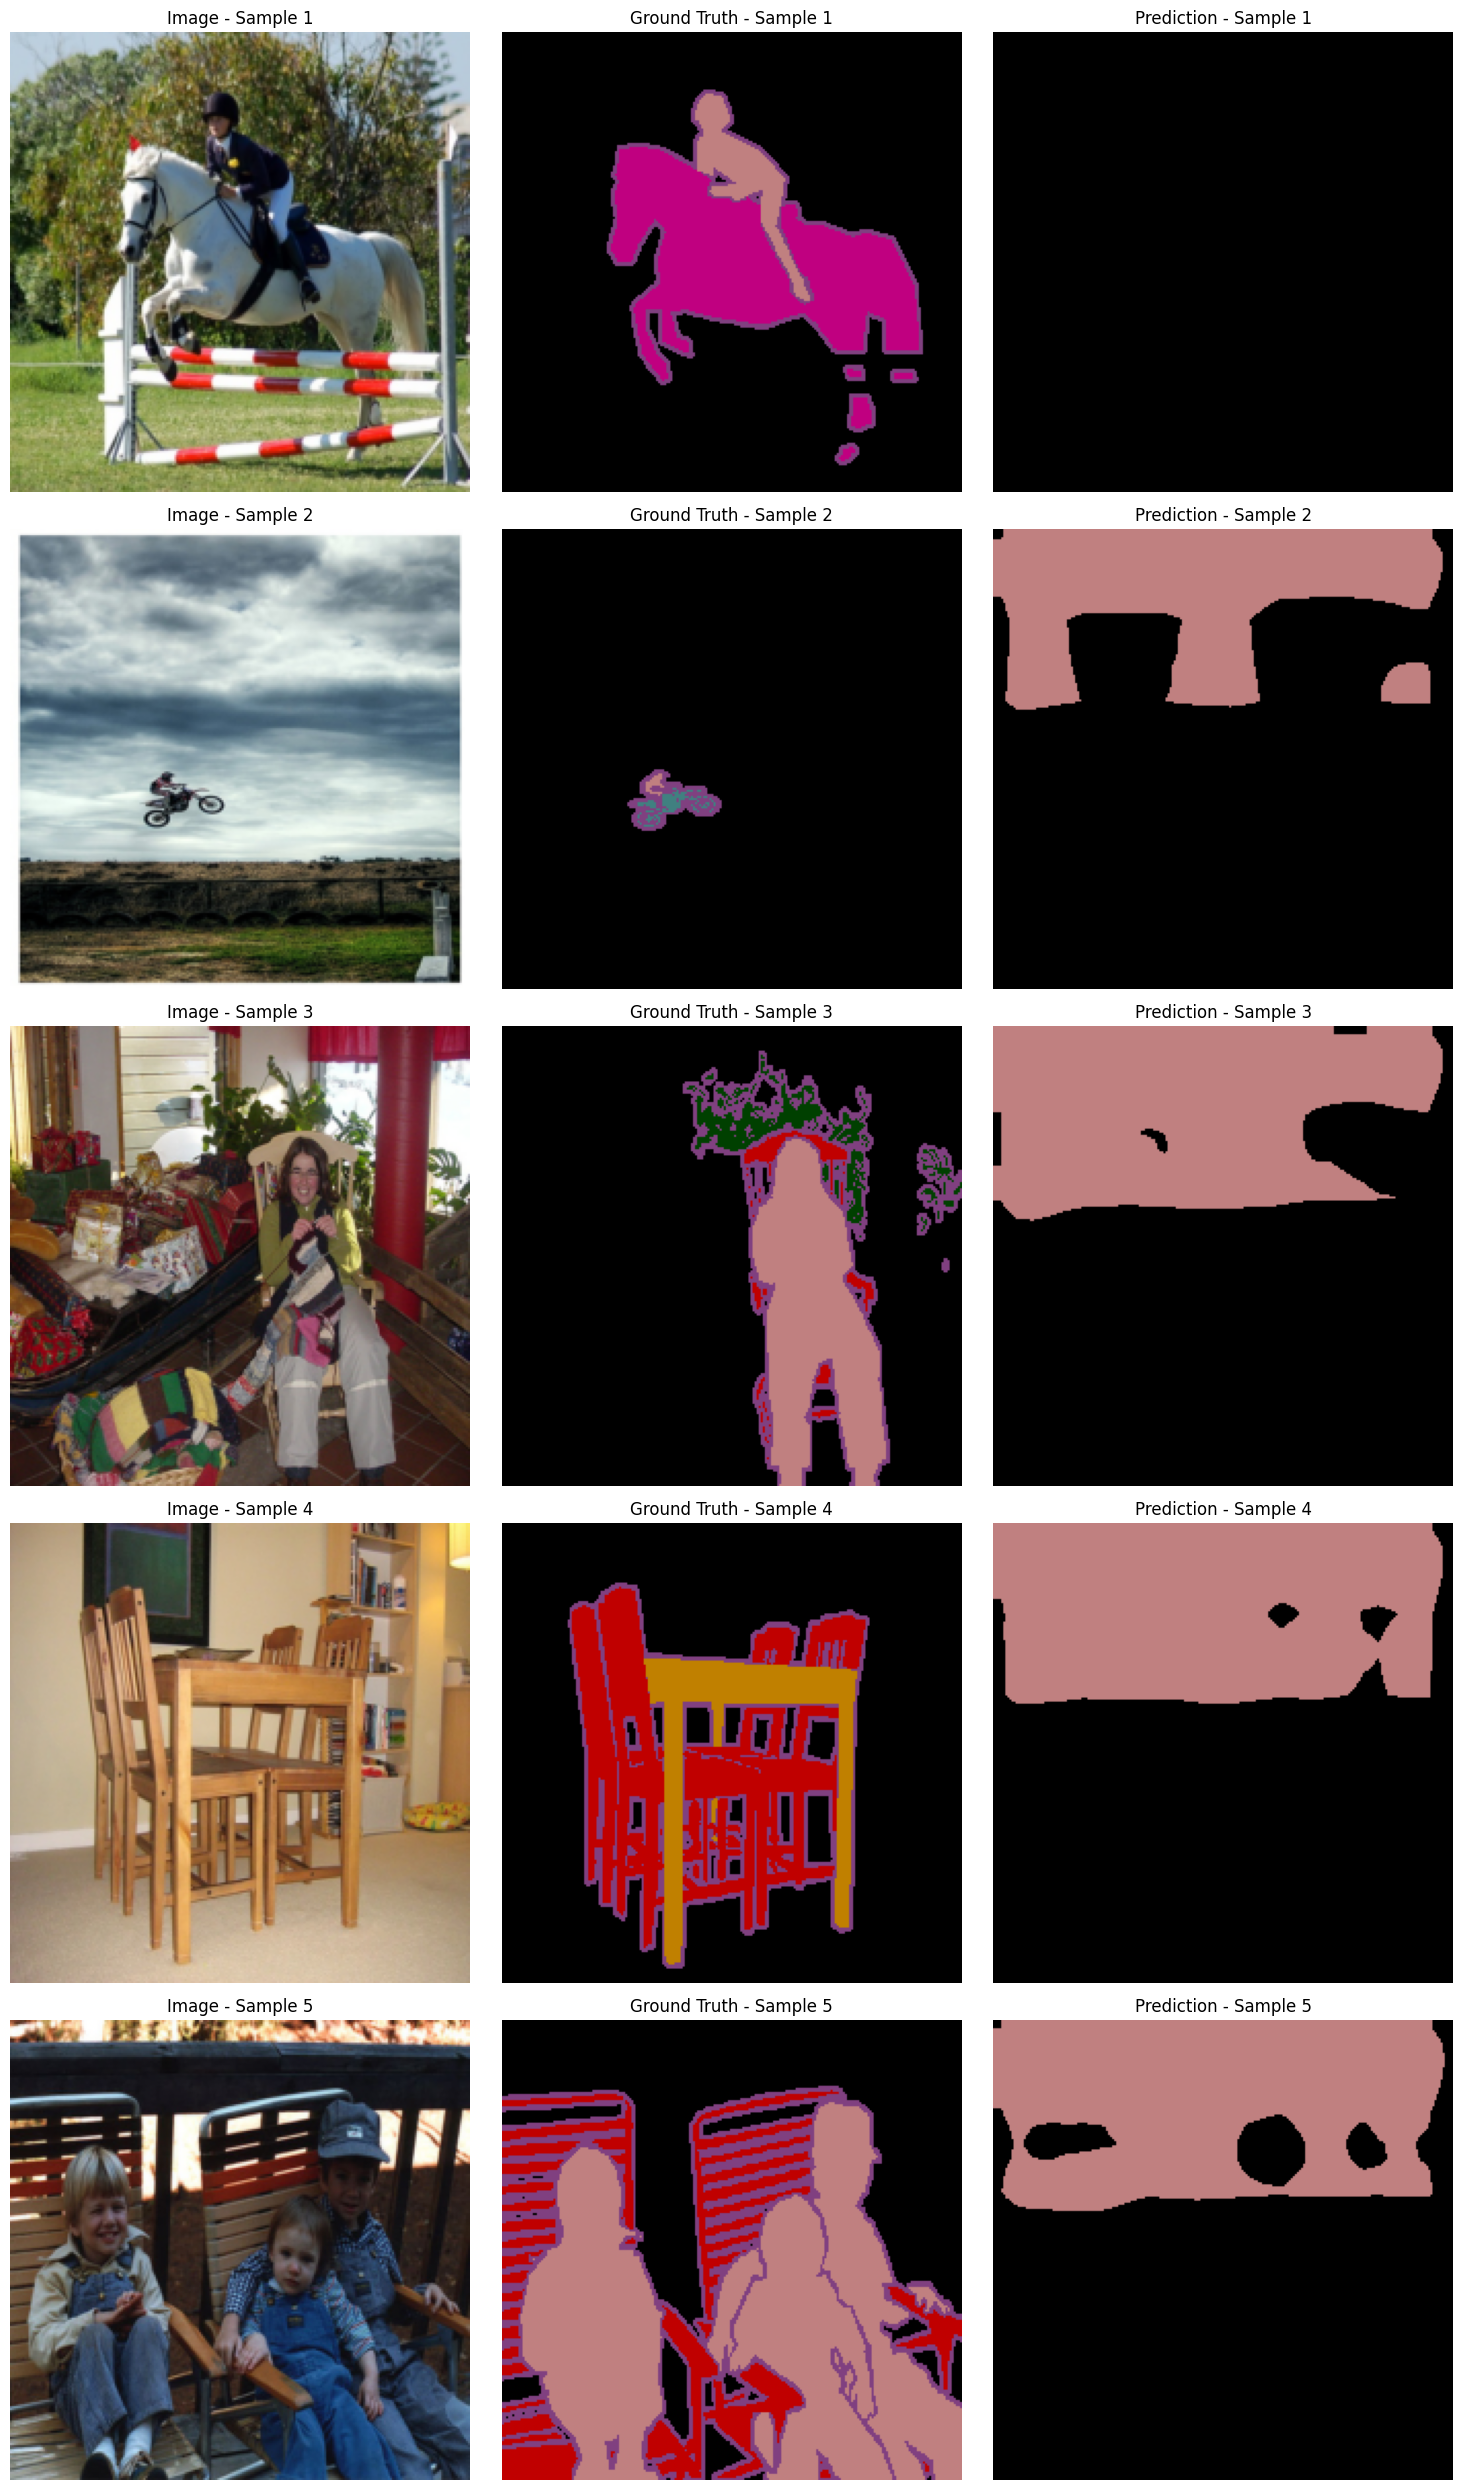

In [11]:
print("\nVisualisation des résultats de validation:")
visualize_validation_results(model=model, val_loader=val_loader, device=device)